## Populaiton analysis

This notebook contains answers related to population development for the different experiments conducted with NSGA-II algorithms for jssp.

Questions:
1. An important aspect of population based optimization is the redundancy of solutions. If the populaiton is full of the same solutions, then the spread in the pareto front will be poor. How unique are the solutions in the best front during different iterations of an experiment?

    It looks like the qubits amplitudes, the resulting bit string and the integer permutation have variations that are inconsistent with the fitness values. it looks like the problem is that the different encodings lead to the same active schedule.

    This problem can also be observed with the classical method (compare the gnatt images of the best front). It looks like similar fintess value typically means same gnatt image.

    Could it be possible to find a representation that is more direcct, which allows us to search the space of active schedules more effectively?

2. When are solutions converged? Would it be beneficial to introduce desaster operations?

    It looks like some qubits are converging fast but some others are keept random.

3. Could it be beneficial to add crossover and mutation in addition to introduce more exploration?

4. The performance plots indicate ocilation with high amplitudes and frequency.

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import re
import pickle

from nsga_population import *
from typing import List
from individual import Individual

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

log_base = "..\\..\\logdata\\"
experiment_folders = ["Experiment_1_2024-10-07_10_28_58_749364"] #["Experiment_1_2024-09-27_classical_1", "Experiment_1_2024-09-30_12_05_58_215187", "Experiment_1_2024-09-30_13_51_09_109136", "Experiment_1_2024-09-30_15_31_13_949606"]


In [2]:
base_path = os.path.join(os.path.join(log_base, experiment_folders[0]), "population_dumps")
dump_names = os.listdir(base_path)

In [3]:
problems = {"ft06" : np.empty(199, dtype=object), "ft10" : np.empty(199, dtype=object), "ft20" : np.empty(199, dtype=object)}
for dump_name in dump_names:
    if "quantum_position_encoding_0" in dump_name:
        index_str = re.findall("_([0-9]+?)\.pkl", dump_name)[0]
        problems[dump_name[:4]][int(index_str)-1] = dump_name

#problems

In [4]:
def get_population(base, target) -> Population:
    cur_path = os.path.join(base, target)
    with open(cur_path, "rb") as read_pop_dump:
        cur_pop = pickle.load(read_pop_dump)

    return cur_pop

In [5]:
population_timeline = problems["ft06"]
df_dict = {"Iteration" : [], "Individual" : [], "makespan" : [], "mean flow time" : [], "µ_a" : [], "µ_b" : []}
cur_pop = get_population(base_path, population_timeline[0])
string_length = cur_pop.R[0].binary_chromosome.reshape(2, -1).shape[-1]
population_img = np.empty(shape=(len(population_timeline), len(cur_pop.R), 2, string_length), dtype=float)
population_img_x = np.empty(shape=(len(population_timeline), len(cur_pop.R), string_length), dtype=float)
population_img_p = np.empty(shape=(len(population_timeline), len(cur_pop.R), cur_pop.R[0].permutation.shape[0]), dtype=float)

for i, filename in enumerate(population_timeline):
    # For each iteration
    cur_pop = get_population(base_path, filename)
    for ind_number, individual in enumerate(cur_pop.R):
        # For each individual in population
        cur_individual_string = (np.abs(individual.binary_chromosome)**2).reshape(2, -1)
        population_img[i, ind_number, :, :] = cur_individual_string
        population_img_x[i, ind_number, :] = individual.x.ravel().astype(int)
        population_img_p[i, ind_number, :] = individual.permutation
        mu_a, mu_b = cur_individual_string.mean(axis=1)
        df_dict["makespan"].append(individual.cur_fitness[0])
        df_dict["mean flow time"].append(individual.cur_fitness[1])
        df_dict["µ_a"].append(mu_a)
        df_dict["µ_b"].append(mu_b)
        df_dict["Individual"].append(ind_number)
        df_dict["Iteration"].append(i)
        
population_df = pd.DataFrame(df_dict)

In [6]:
population_img.shape

(199, 100, 2, 108)

In [7]:
# Normalized permutation numbers
population_img_p = population_img_p/population_img_p.max()

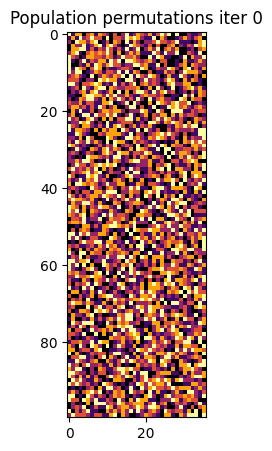

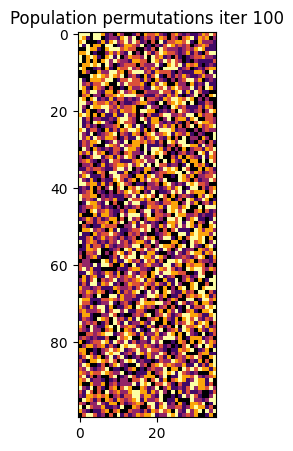

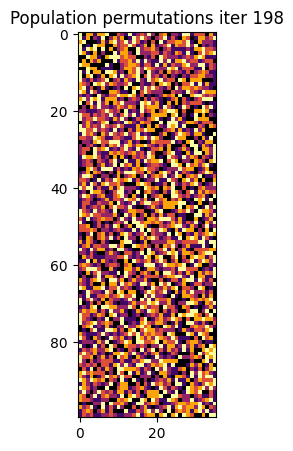

In [8]:
fig = plt.figure(figsize=(20, 5))
plt.title("Population permutations iter " + str(0))
plt.imshow(population_img_p[0, :, :], cmap="inferno")
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.title("Population permutations iter " + str(100))
plt.imshow(population_img_p[100, :, :], cmap="inferno")
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.title("Population permutations iter " + str(198))
plt.imshow(population_img_p[198, :, :], cmap="inferno")
plt.show()

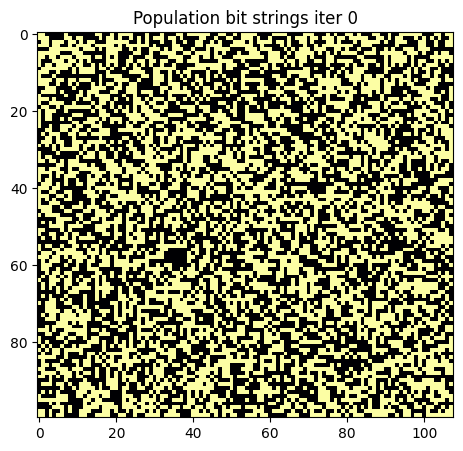

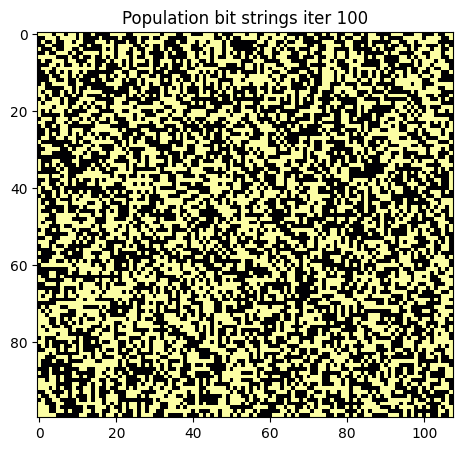

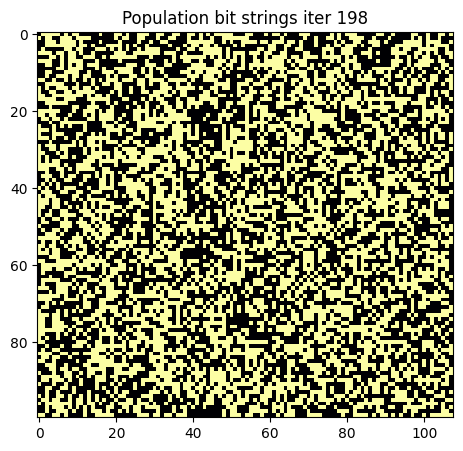

In [9]:
fig = plt.figure(figsize=(20, 5))
plt.title("Population bit strings iter " + str(0))
plt.imshow(population_img_x[0, :, :], cmap="inferno")
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.title("Population bit strings iter " + str(100))
plt.imshow(population_img_x[80, :, :], cmap="inferno")
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.title("Population bit strings iter " + str(198))
plt.imshow(population_img_x[198, :, :], cmap="inferno")
plt.show()

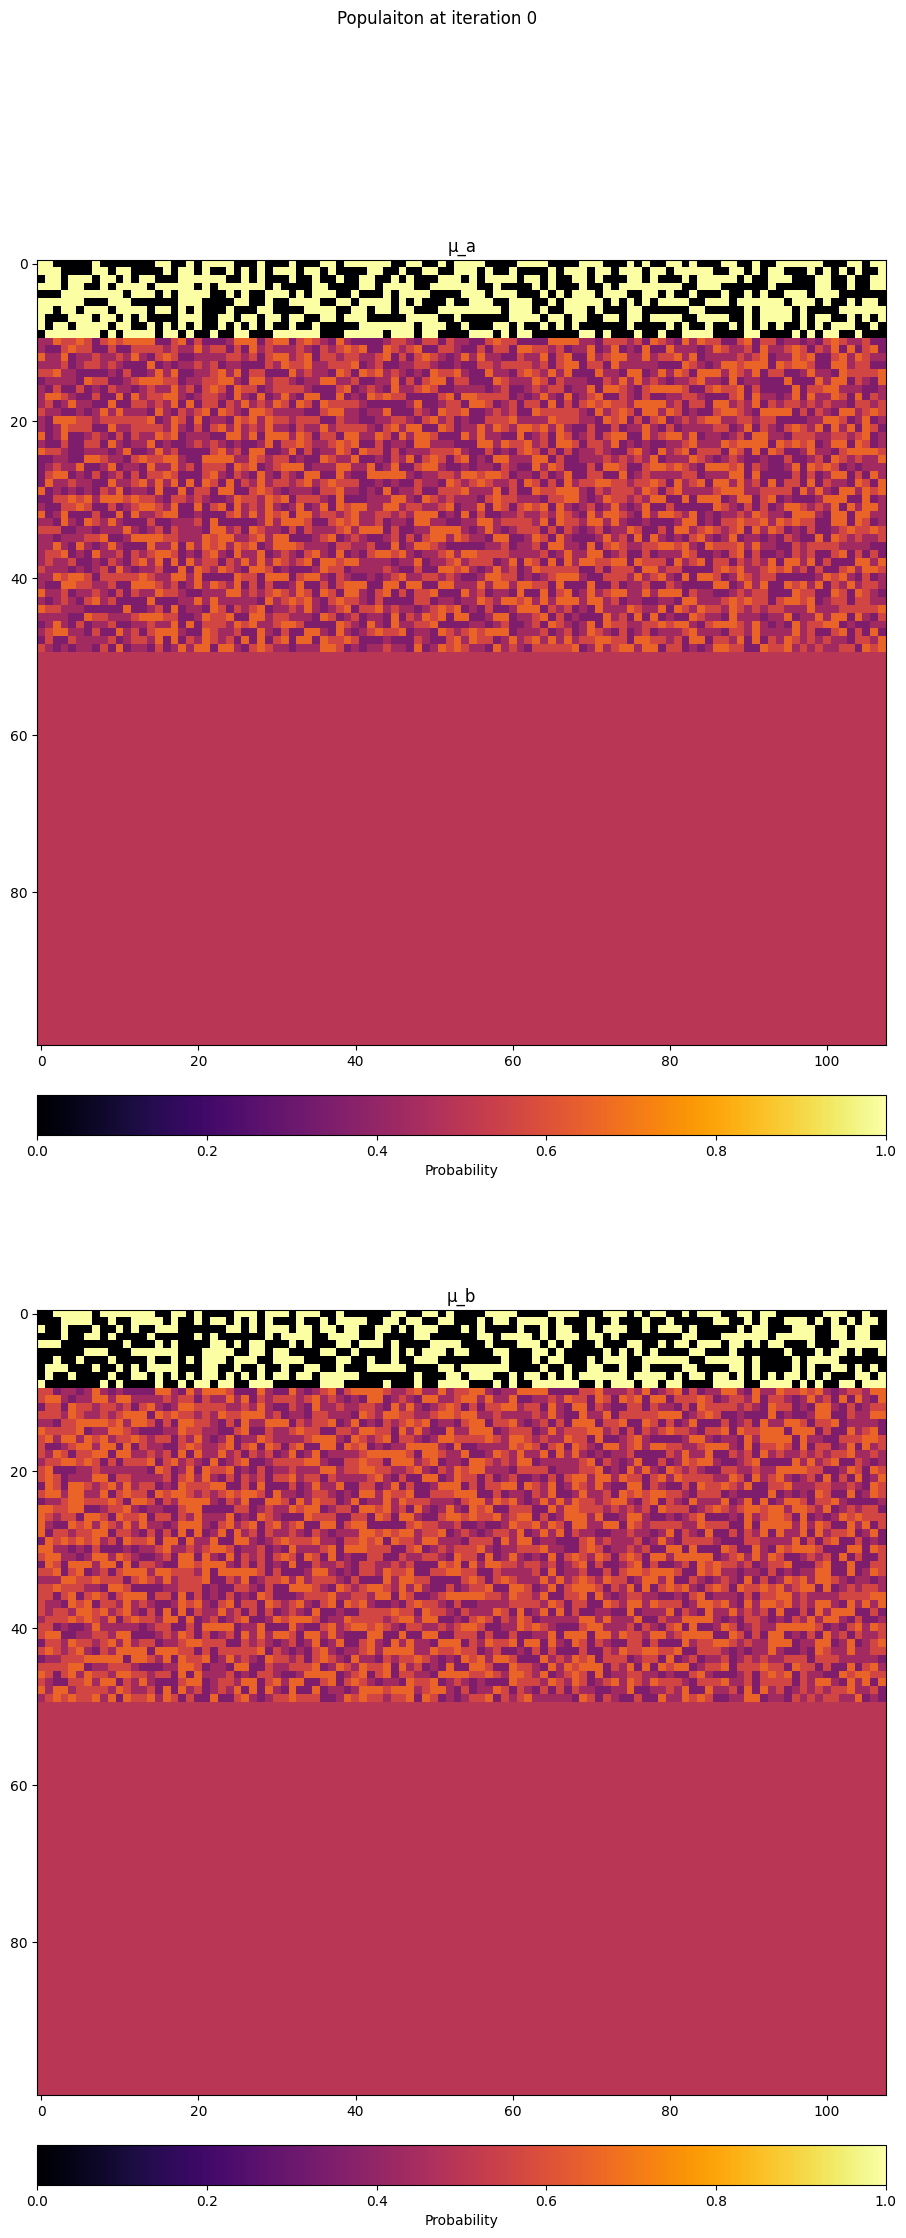

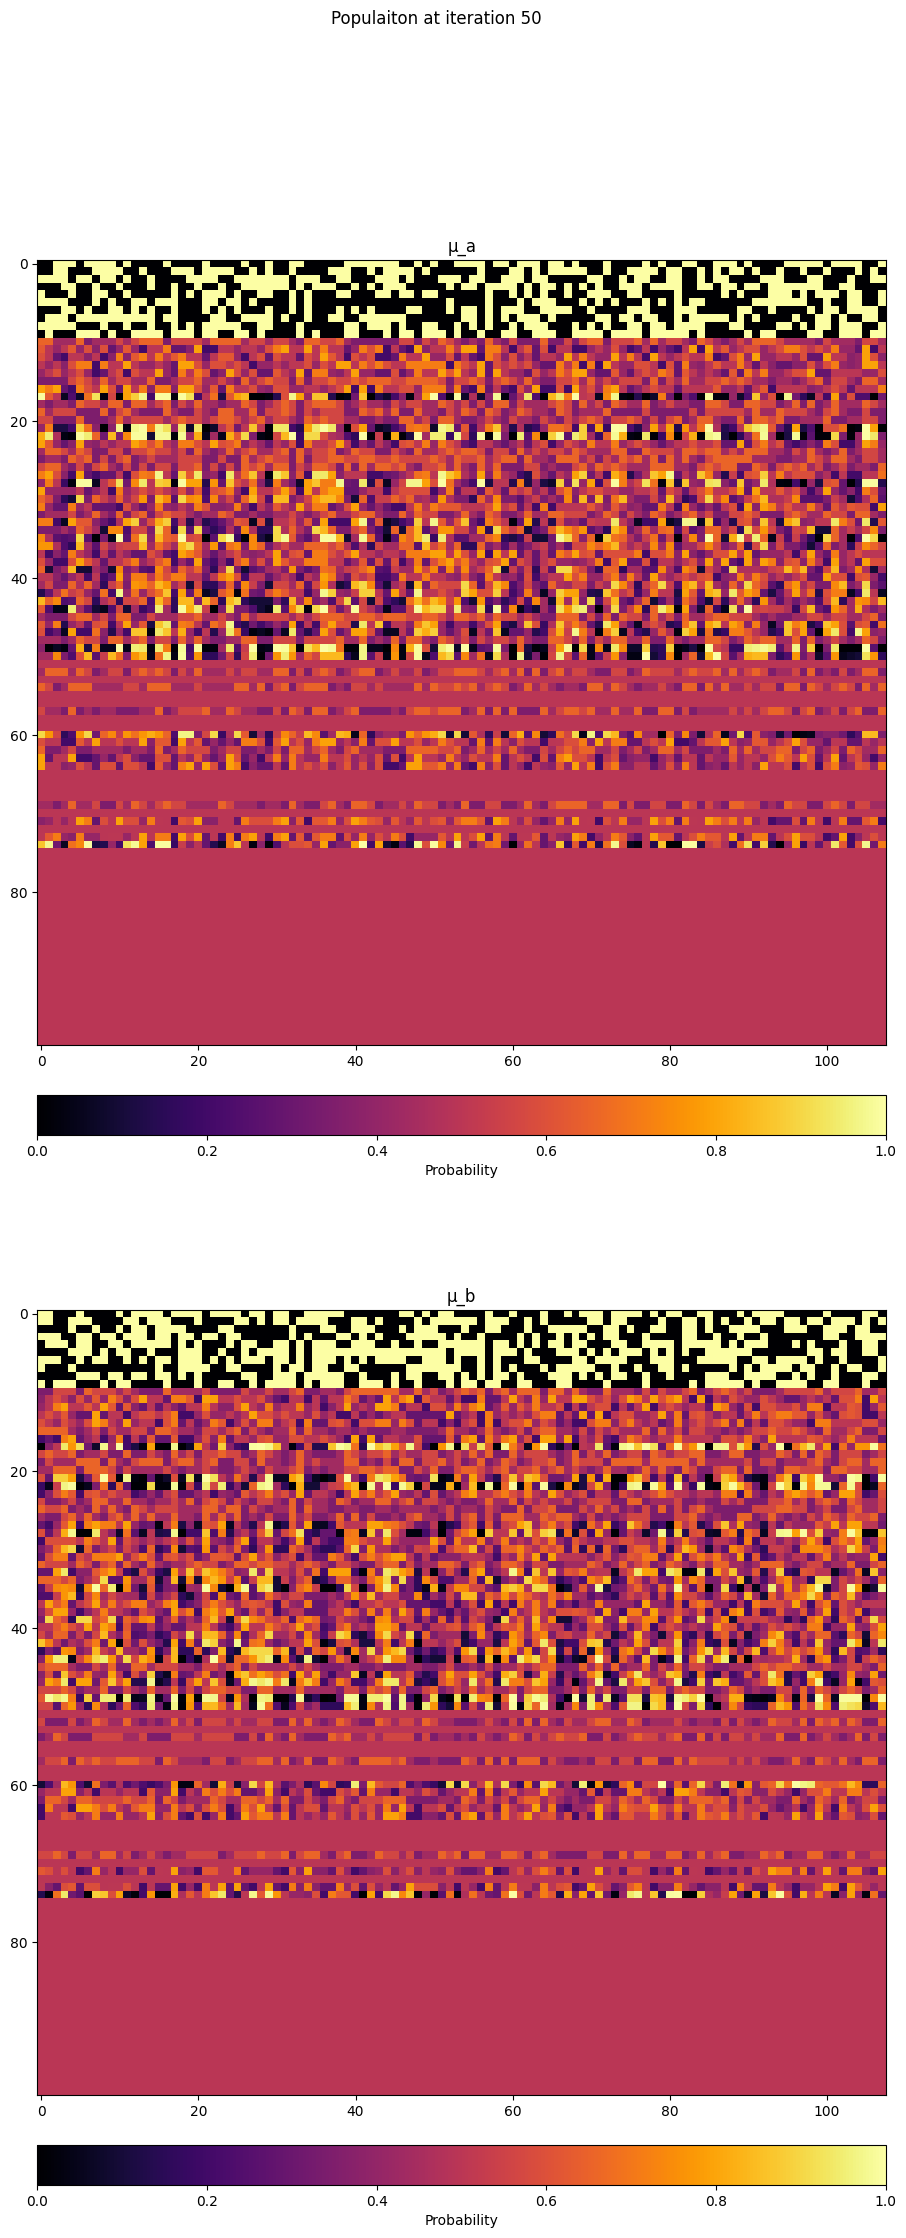

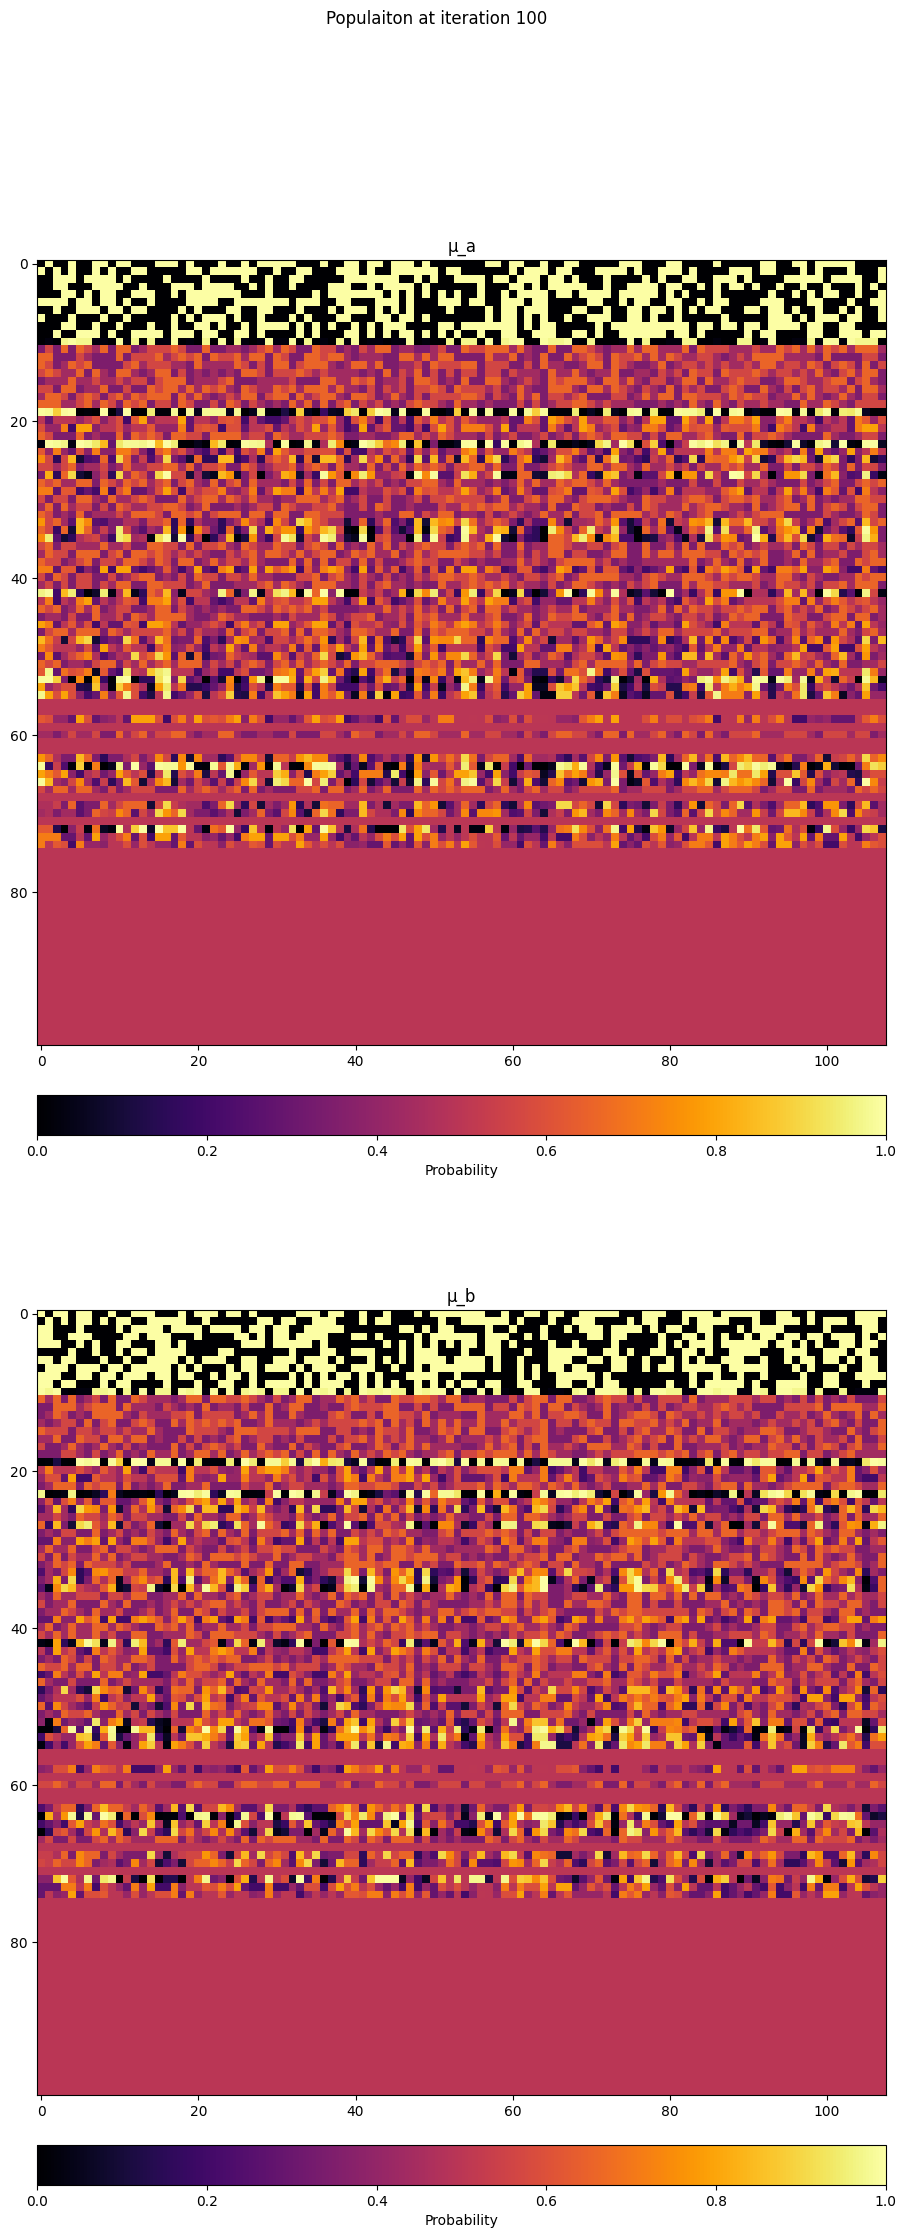

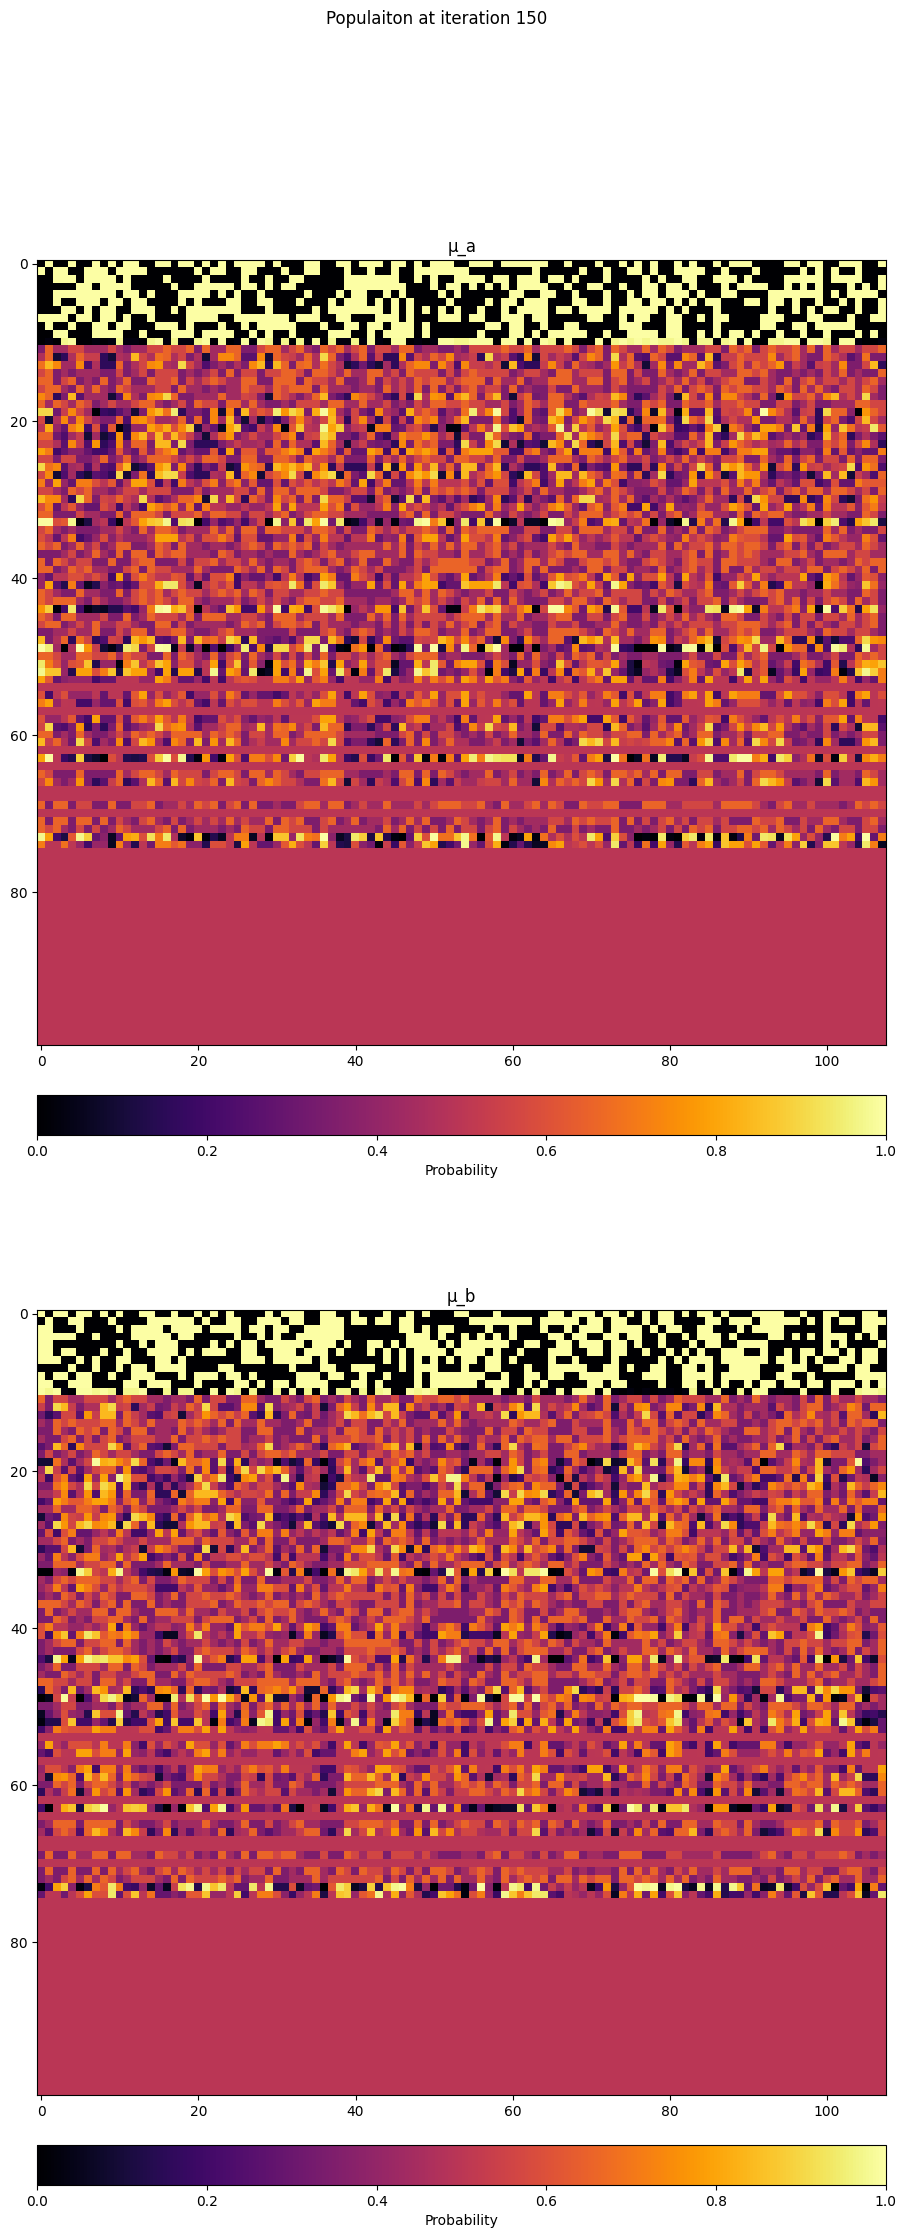

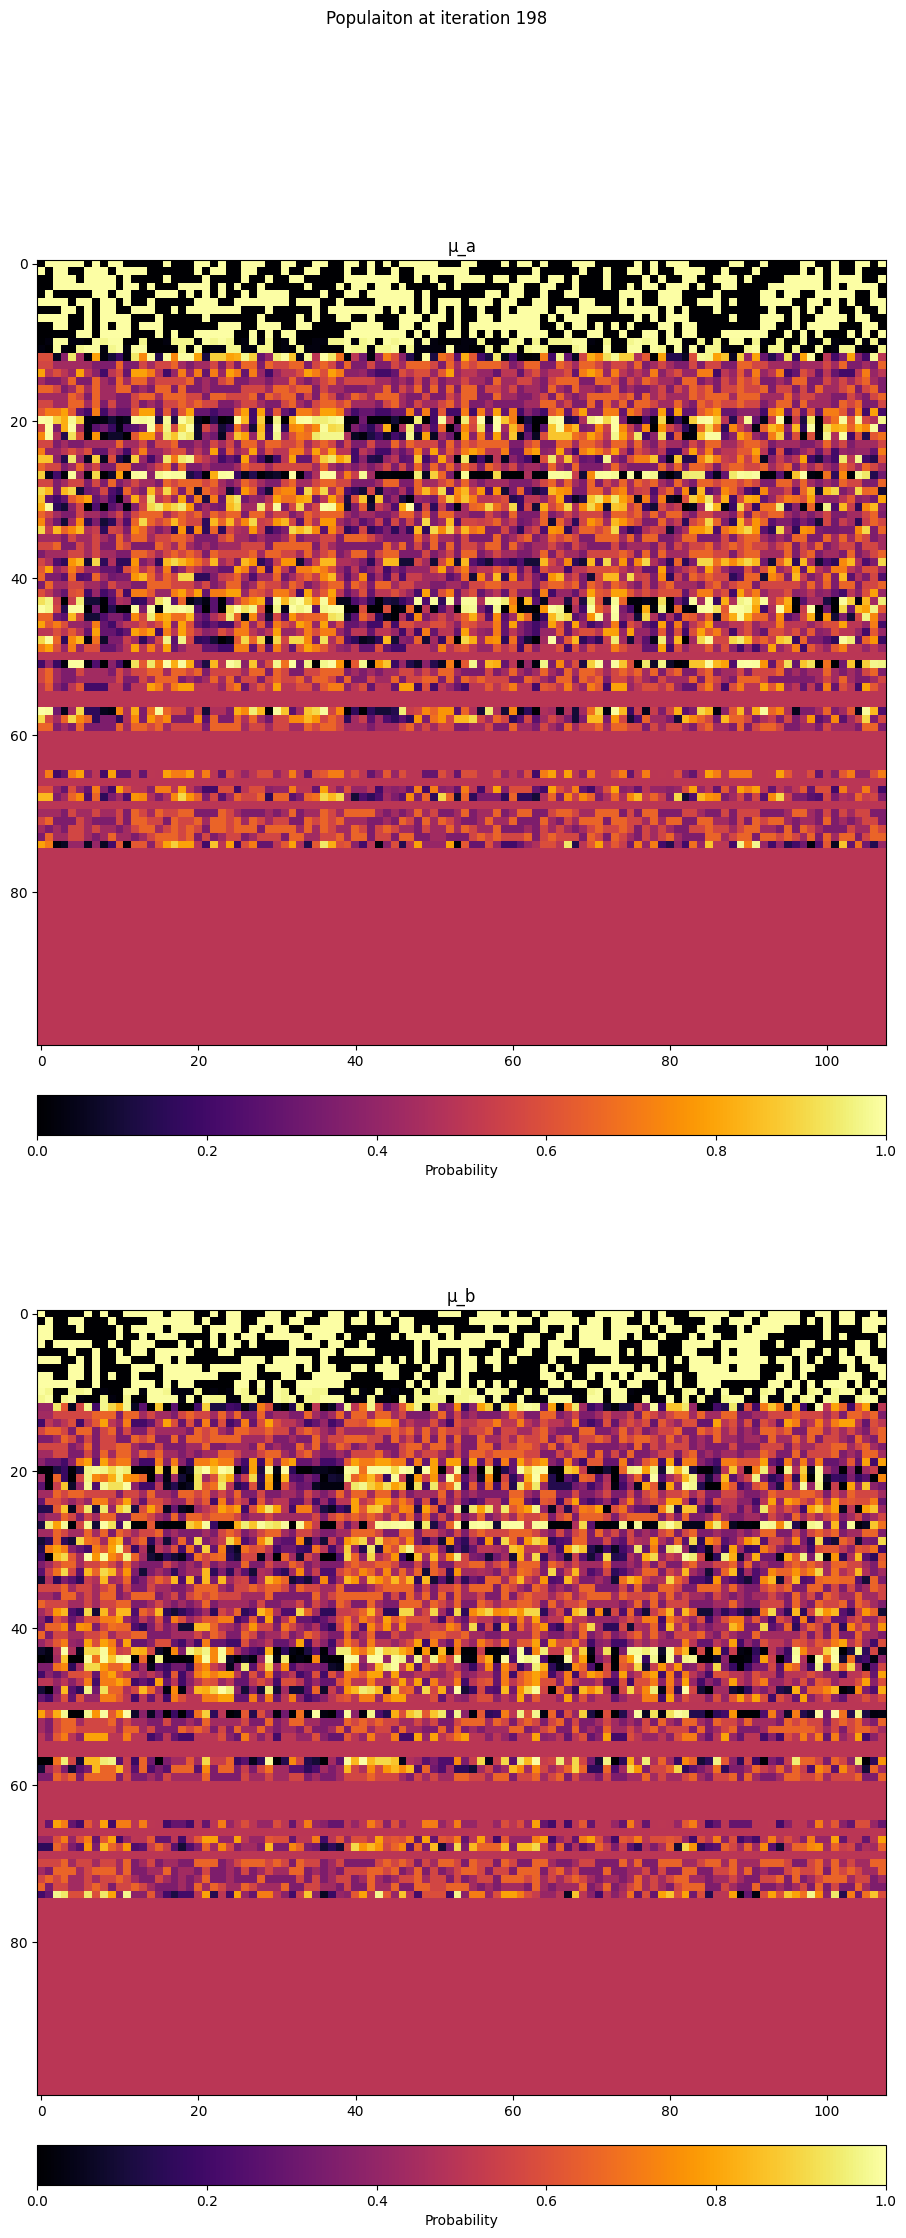

In [10]:
for i in range(199):
    if i % 50 == 0 or i == 198:
        merged_img_a = population_img[:, :, 0, :].reshape(199, -1, population_img.shape[-1])
        merged_img_b = population_img[:, :, 1, :].reshape(199, -1, population_img.shape[-1])
        fig, ax = plt.subplots(2, 1, figsize=(20, 25))
        plt.suptitle("Populaiton at iteration " + str(i))

        ax[0].set_title("µ_a")
        im1 = ax[0].imshow(merged_img_a[i, :, :], cmap="inferno", vmax=1, vmin=0)

        ax[1].set_title("µ_b")
        im2 = ax[1].imshow(merged_img_b[i, :, :], cmap="inferno", vmax=1, vmin=0)

        divider1 = make_axes_locatable(ax[0])
        cax1 = divider1.append_axes("bottom", size="5%", pad=0.5)
        divider2 = make_axes_locatable(ax[1])
        cax2 = divider2.append_axes("bottom", size="5%", pad=0.5)

        fig.colorbar(im1, label="Probability", orientation="horizontal", cax=cax1)
        fig.colorbar(im2, label="Probability", orientation="horizontal", cax=cax2)
        plt.show()

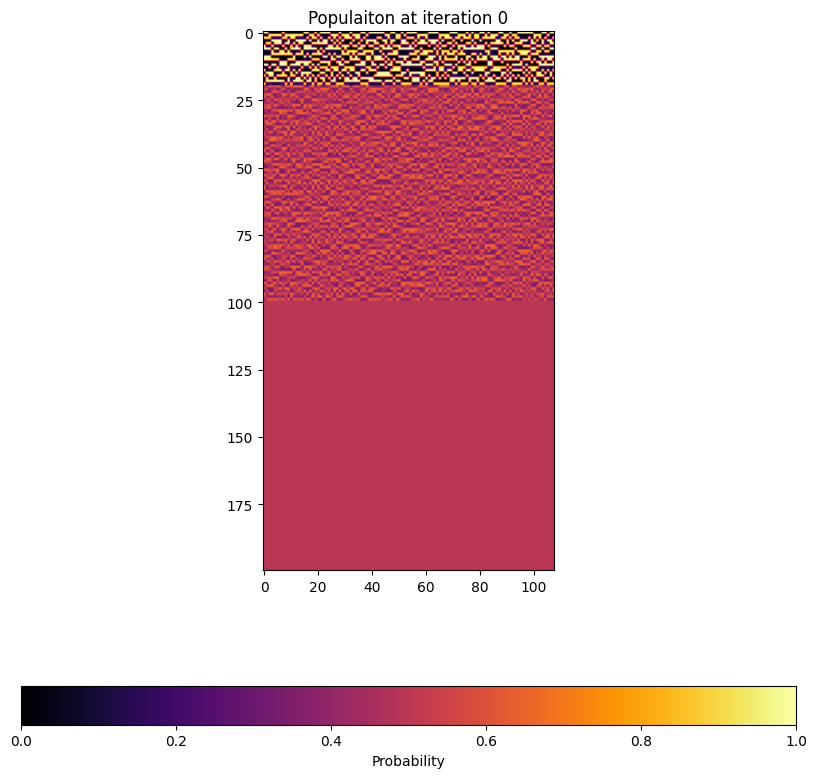

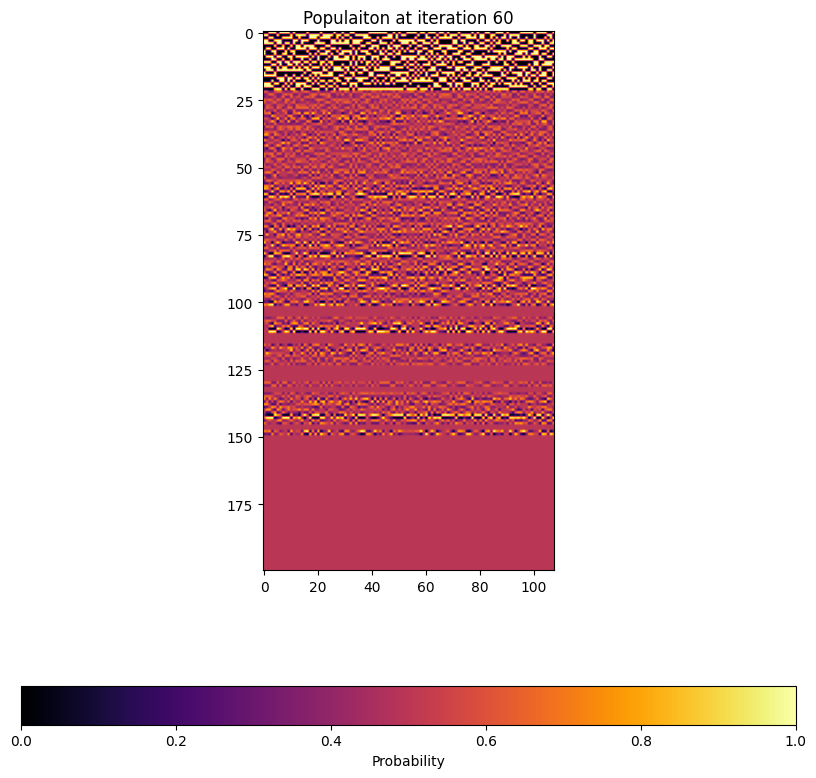

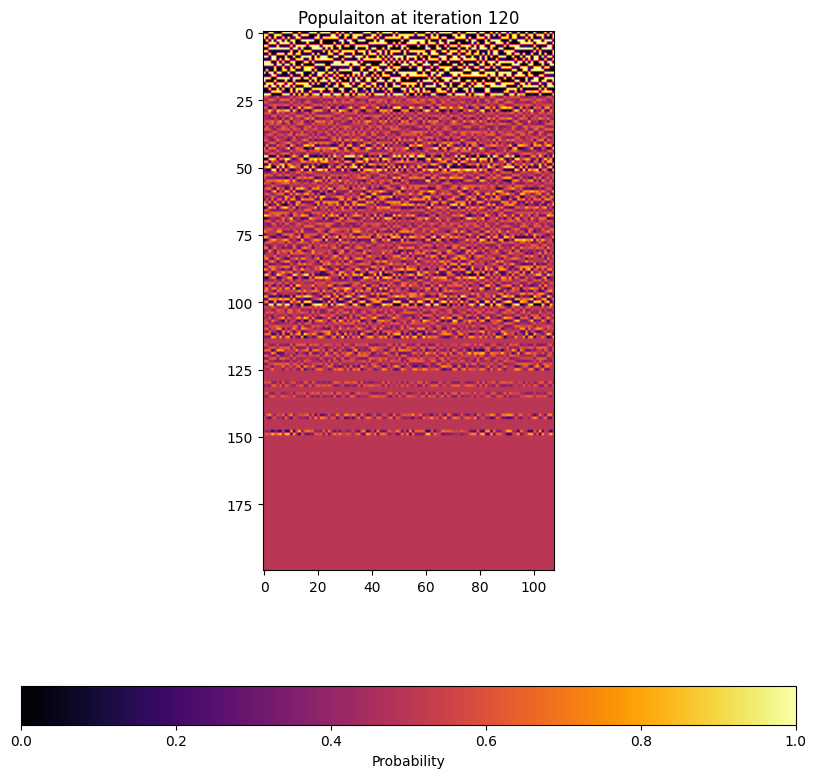

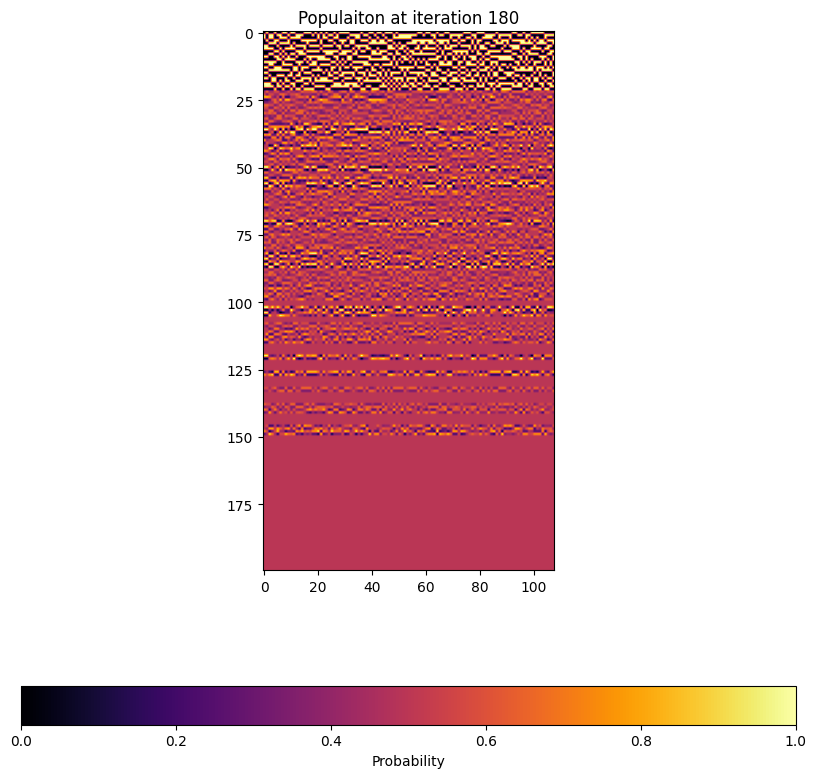

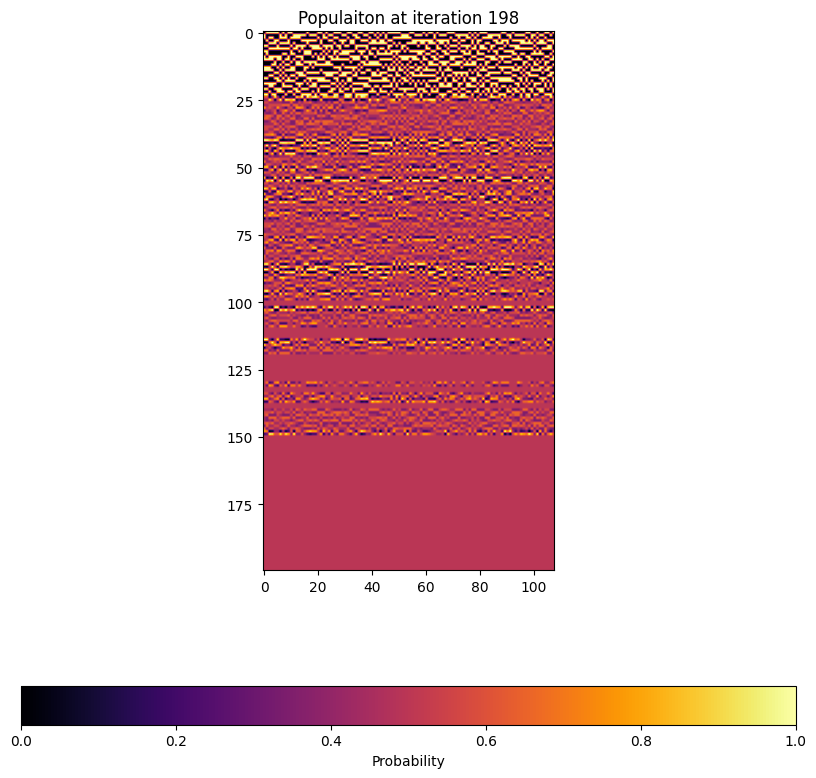

In [11]:
for i in range(199):
    if i % 60 == 0 or i == 198:
        merged_img = population_img.reshape(199, -1, population_img.shape[-1])
        plt.figure(figsize=(10, 10))
        plt.title("Populaiton at iteration " + str(i))
        plt.imshow(merged_img[i, :, :], cmap="inferno")
        plt.colorbar(label="Probability", orientation="horizontal")
        plt.show()

In [12]:
population_df.columns[-2:]

Index(['µ_a', 'µ_b'], dtype='object')

In [ ]:
population_df

,Iteration,Individual,makespan,mean flow time,µ_a,µ_b
0,0,0,59.0,48.666667,0.481481,0.518519
1,0,1,58.0,53.666667,0.518519,0.481481
2,0,2,59.0,49.833333,0.527778,0.472222
3,0,3,59.0,50.166667,0.546296,0.453704
4,0,4,59.0,50.333333,0.537037,0.462963
...,...,...,...,...,...,...
19895,198,95,66.0,53.500000,0.500000,0.500000
19896,198,96,60.0,53.833333,0.500000,0.500000
19897,198,97,68.0,52.166667,0.500000,0.500000
19898,198,98,66.0,54.833333,0.500000,0.500000


In [14]:
test_melt_df = population_df.melt(id_vars=population_df.columns[:-2], value_vars=population_df.columns[-2:])

In [ ]:
test_melt_df

,Iteration,Individual,makespan,mean flow time,variable,value
0,0,0,59.0,48.666667,µ_a,0.481481
1,0,1,58.0,53.666667,µ_a,0.518519
2,0,2,59.0,49.833333,µ_a,0.527778
3,0,3,59.0,50.166667,µ_a,0.546296
4,0,4,59.0,50.333333,µ_a,0.537037
...,...,...,...,...,...,...
39795,198,95,66.0,53.500000,µ_b,0.500000
39796,198,96,60.0,53.833333,µ_b,0.500000
39797,198,97,68.0,52.166667,µ_b,0.500000
39798,198,98,66.0,54.833333,µ_b,0.500000


In [16]:
test_melt_df[(test_melt_df["Iteration"] == 0) & (test_melt_df["value"] == 1.0)]

,Iteration,Individual,makespan,mean flow time,variable,value


In [17]:
test_melt_df[test_melt_df["Iteration"] == 0]["value"].value_counts()

value
0.500000    100
0.497679      3
0.518519      3
0.481481      3
0.537037      2
           ... 
0.503322      1
0.505723      1
0.507193      1
0.483683      1
0.500620      1
Name: count, Length: 86, dtype: int64

In [ ]:
individual.schedule.get_image().shape

(400, 1000, 3)

<Axes: xlabel='Individual', ylabel='Mean flow time'>

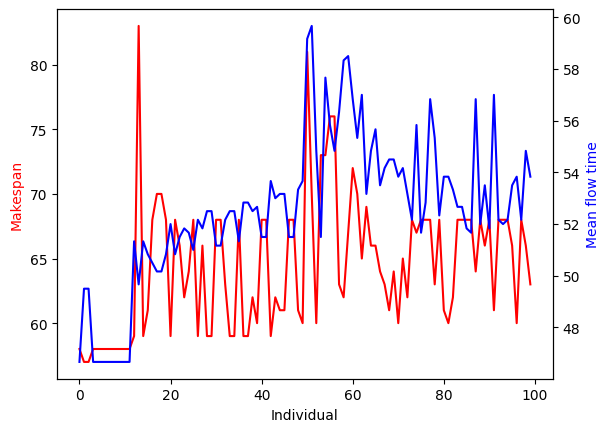

In [19]:
iteration = 198
ax = sns.lineplot(data=test_melt_df[(test_melt_df["variable"] == "µ_a") & (test_melt_df["Iteration"] == iteration)], x="Individual", y="makespan", color="r")
ax.set_ylabel("Makespan", color="r")
ax2 = ax.twinx()
ax2.set_ylabel("Mean flow time", color="b")
sns.lineplot(data=test_melt_df[(test_melt_df["variable"] == "µ_a") & (test_melt_df["Iteration"] == iteration)], x="Individual", y="mean flow time", color="b", ax=ax2)


<Axes: xlabel='Individual', ylabel='value'>

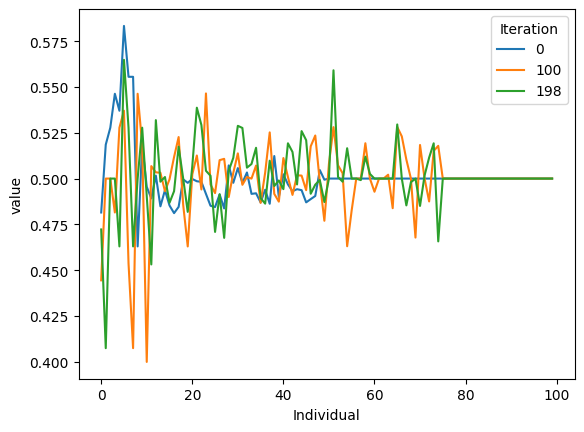

In [20]:
sns.lineplot(data=test_melt_df[(test_melt_df["variable"] == "µ_a") & (test_melt_df["Iteration"].isin([0, 100, 198]))], x="Individual", y="value", hue="Iteration", palette="tab10")

<Axes: xlabel='Individual', ylabel='value'>

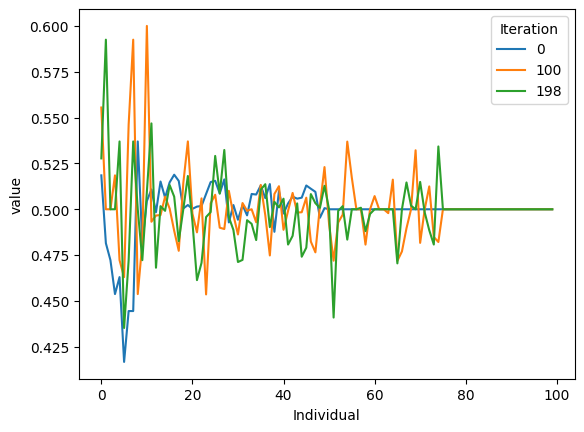

In [21]:
sns.lineplot(data=test_melt_df[(test_melt_df["variable"] == "µ_b") & (test_melt_df["Iteration"].isin([0, 100, 198]))], x="Individual", y="value", hue="Iteration", palette="tab10")

In [22]:
cur_x = np.random.randint(0, 2, size=20, dtype=bool)
b_mask = np.zeros(20, dtype=bool)
b_mask[[0, 3, 5]] = True
cur_b = np.logical_xor(cur_x, b_mask)
cached_shape = cur_b.shape
cur_b

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False,  True, False, False, False,  True, False,  True, False,
       False, False])

In [23]:
cur_x

array([False, False,  True, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True, False,  True, False,
       False, False])

In [24]:
binary_chromosome = np.ones((2, 20)) * 1/np.sqrt(2)
binary_chromosome

array([[0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678],
       [0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
        0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678]])

In [25]:
binary_chromosome = np.ones((2, 20)) * 1/np.sqrt(2)

In [26]:
cur_x = np.random.randint(0, 2, size=20, dtype=bool)
b_mask = np.zeros(20, dtype=bool)
b_mask[[0, 3, 5]] = True
cur_b = np.logical_xor(cur_x, b_mask)
cached_shape = cur_b.shape


rotation_angles = np.array(eval("[0.02*np.pi, 0, 0.05*np.pi, 0, 0.05*np.pi, 0, 0.05*np.pi, 0, 0.02*np.pi]")) #np.repeat([raw_rotation_angles], self.n_bits*self.n_jobs*self.n_machines, axis=0)
#rotation_angles = rotation_angles.reshape(self.n_machines, self.n_bits*self.n_jobs, -1)

signs = np.array([-1, 0, 1, 0, -1, 0, 1, 0]) #np.repeat([np.array([-1, 0, 1, 0, -1, 0, 1, 0])], self.n_bits*self.n_jobs*self.n_machines, axis=0)
#signs = signs.reshape(self.n_machines, self.n_jobs*self.n_bits, -1)
#for i in range(len(cur_x)):
pi = cur_x.astype(int) * (2**2)
bi = cur_b.astype(int) * (2**1)
better = int(False) 
index = (pi + bi + better).ravel() #int(str(pi) + str(bi) + str(better), 2)
cur_sign = (binary_chromosome[0, ...] * binary_chromosome[1, ...]) < 0
cur_angle = rotation_angles[index] * signs[index] * (((-2)*cur_sign.ravel()) +  1)
cur_angle = cur_angle.reshape(cached_shape)
# Apply the rotation
new_a = binary_chromosome[0, ...]*np.cos(cur_angle) - binary_chromosome[1, ...]*np.sin(cur_angle)
new_b = binary_chromosome[0, ...]*np.sin(cur_angle) + binary_chromosome[1, ...]*np.cos(cur_angle)

print("Cur angle:" + str(cur_angle))

print(new_a)
print(new_b)

binary_chromosome[0, ...] = new_a
binary_chromosome[1, ...] = new_b

print(np.sum(binary_chromosome**2, axis=0))
    


Cur angle:[-0.15707963  0.15707963  0.15707963 -0.15707963 -0.06283185  0.15707963
 -0.06283185 -0.06283185  0.15707963  0.15707963 -0.06283185 -0.06283185
 -0.06283185  0.15707963  0.15707963  0.15707963  0.15707963 -0.06283185
 -0.06283185  0.15707963]
[0.80901699 0.58778525 0.58778525 0.80901699 0.75011107 0.58778525
 0.75011107 0.75011107 0.58778525 0.58778525 0.75011107 0.75011107
 0.75011107 0.58778525 0.58778525 0.58778525 0.58778525 0.75011107
 0.75011107 0.58778525]
[0.58778525 0.80901699 0.80901699 0.58778525 0.66131187 0.80901699
 0.66131187 0.66131187 0.80901699 0.80901699 0.66131187 0.66131187
 0.66131187 0.80901699 0.80901699 0.80901699 0.80901699 0.66131187
 0.66131187 0.80901699]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
np.sin(np.pi/2)

1.0

In [28]:
binary_chromosome[0, ...]

array([0.80901699, 0.58778525, 0.58778525, 0.80901699, 0.75011107,
       0.58778525, 0.75011107, 0.75011107, 0.58778525, 0.58778525,
       0.75011107, 0.75011107, 0.75011107, 0.58778525, 0.58778525,
       0.58778525, 0.58778525, 0.75011107, 0.75011107, 0.58778525])

In [29]:
index

array([4, 6, 6, 4, 0, 2, 0, 0, 6, 6, 0, 0, 0, 6, 6, 6, 6, 0, 0, 6])

In [30]:
signs[index]

array([-1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
       -1, -1,  1])

In [31]:
rotation_angles[index]

array([0.15707963, 0.15707963, 0.15707963, 0.15707963, 0.06283185,
       0.15707963, 0.06283185, 0.06283185, 0.15707963, 0.15707963,
       0.06283185, 0.06283185, 0.06283185, 0.15707963, 0.15707963,
       0.15707963, 0.15707963, 0.06283185, 0.06283185, 0.15707963])

In [32]:
np.all(np.sum(binary_chromosome**2, axis=0) >= 1)

False

In [33]:
np.sum(binary_chromosome**2, axis=0)[0]

1.0

In [34]:
np.sum(np.array([[1,2,3],[1,2,3]]), axis=0)

array([2, 4, 6])

In [35]:
cur_angle[0]

-0.15707963267948966